## Reinforcement Learning

### Introduction to OpenAI Gym

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 44.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [16 lines of output]
      Using setuptools (version 65.5.0).
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-310
      creating build/lib.linux-x86_64-cpython-310/Box2D
      copying library/Box2D/__init__.py -> build/lib.linux-x86_64-cpython-310/Box2D
      copying library/Box2D/Box2D.py -> build/lib.linux-x86_64-cpython-310/Box2D
      creating build/lib.linux-x86_

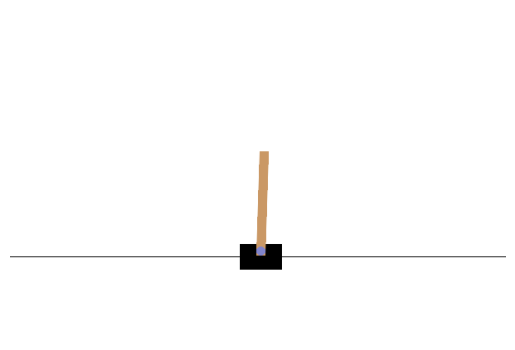

/root/venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/root/venv/lib/python3.10/site-packages/gym/envs/classic_control/cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


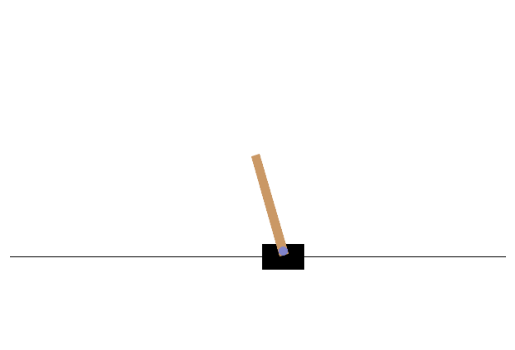

In [1]:
%pip install --upgrade pip
%pip install -q -U gym
%pip install -q -U gym[classic_control]
%pip install -q -U gym[box2d]
%pip install -q -U gym[atari]
%pip install -q -U gym[accept-rom-license]
import gym
import matplotlib.pyplot as plt

env = gym.make('CartPole-v1', render_mode='rgb_array')
obs, info = env.reset(seed=42)

img = env.render()

plt.imshow(img)
plt.axis("off")
plt.show()

action = 1
for a in range(10):
    env.step(action)
obs, reward, done, truncated, info = env.step(action)

img = env.render()

plt.imshow(img)
plt.axis("off")
plt.show()

In [22]:
%pip install --upgrade pip
%pip install -q -U gym
%pip install -q -U gym[classic_control]
%pip install -q -U gym[box2d]
%pip install -q -U gym[atari]
%pip install -q -U gym[accept-rom-license]
import gym
import matplotlib.pyplot as plt
import numpy as np

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

env = gym.make('CartPole-v1', render_mode='rgb_array')

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

np.mean(totals), np.std(totals), min(totals), max(totals)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [16 lines of output]
      Using setuptools (version 65.5.0).
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-310
      creating build/lib.linux-x86_64-cpython-310/Box2D
      copying library/Box2D/__init__.py -> build/lib.linux-x86_64-cpython-310/Box2D
      copying library/Box2D/Box2D.py -> build/lib.linux-x86_64-cpython-310/Box2D
      creating build/lib.linux-x86_64-cpython-310/Box2D/b2
      copying library/Box2D/b2/__init__.py -> build/lib.linux-x86_64-cpython-310/Box2D/b2
      running build_ext
      building 'Box2D._Box2D' extension
      swigging Box2D/Box2D.i to Box2D/Box2D_

(41.698, 8.389445512070509, 24.0, 63.0)

### Policy Gradients

In [1]:
%pip install --upgrade pip
%pip install -q -U gym
%pip install -q -U gym[classic_control]
%pip install -q -U gym[box2d]
%pip install -q -U gym[atari]
%pip install -q -U gym[accept-rom-license]
import gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in (range(len(rewards) - 2, -1, -1)):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy
env = gym.make('CartPole-v1', render_mode='rgb_array')

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env,
        n_episodes_per_update,
        n_max_steps,
        model, 
        loss_fn
    )
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
                for episode_index, final_rewards in enumerate(all_final_rewards)
                    for step, final_reward in enumerate(final_rewards)
            ],
            axis=0
        )
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 39.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [16 lines of output]
      Using setuptools (version 65.5.0).
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-310
      creating build/lib.linux-x86_64-cpython-310/Box2D
      copying library/Box2D/__init__.py -> build/lib.linux-x86_64-cpython-310/Box2D
      copying library/Box2D/Box2D.py -> build/lib.linux-x86_64-cpython-310/Box2D
      creating build/lib.linux-x86_

### Markov Decision Processes

In [7]:
import numpy as np

transition_probabilities = [
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]
prossible_actions = [[0, 1, 2], [0, 2], [1]]

Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(prossible_actions):
    Q_values[state][actions] = 0.0

gamma = 0.90

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in prossible_actions[s]:
            Q_values[s, a] = np.sum([
                transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * Q_prev[sp].max())
                for sp in range(3)
            ])

print(Q_values)

[[18.91891892 17.02702702 13.62162162]
 [ 0.                -inf -4.87971488]
 [       -inf 50.13365013        -inf]]


### Q-Learning

In [10]:
import numpy as np

transition_probabilities = [
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]
prossible_actions = [[0, 1, 2], [0, 2], [1]]

Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(prossible_actions):
    Q_values[state][actions] = 0.0

def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

def exploration_policy(state):
    return np.random.choice(prossible_actions[state])

alpha0 = 0.05
decay = 0.005
gamma = 0.90
state = 0

for iteration in range(10000):
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = Q_values[next_state].max()
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

print(Q_values)

[[18.69931147 16.20308925 12.93873634]
 [ 0.                -inf -9.32511006]
 [       -inf 47.80763265        -inf]]


### Implementing Deep Q-Learning

In [16]:
import tensorflow as tf
import numpy as np
from collections import deque
import gym

def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model(state[np.newaxis])[0]
        return Q_values.numpy().argmax()

def sample_experience(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]

def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

def training_step(batch_size):
    experiences = sample_experience(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

input_shape = [4]
n_outputs = 2
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

replay_buffer = deque(maxlen=2000)
env = gym.make('CartPole-v1', render_mode='rgb_array')

for episode in range(600):
    obs, info = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done:
            break
    if episode > 50:
        training_step(batch_size)

1/1 [==============================] - 0s 43ms/step


### OpenAI Gym’s LunarLander-v2 Environment

Get:1 http://deb.debian.org/debian bullseye InRelease [116 kB]
Get:2 http://deb.debian.org/debian-security bullseye-security InRelease [27.2 kB]
Get:3 http://deb.debian.org/debian bullseye-updates InRelease [44.1 kB]
Get:4 http://deb.debian.org/debian bullseye/main amd64 Packages [8,066 kB]
Get:5 http://deb.debian.org/debian-security bullseye-security/main amd64 Packages [359 kB]
Get:6 http://deb.debian.org/debian bullseye-updates/main amd64 Packages [18.8 kB]
Fetched 8,631 kB in 2s (3,601 kB/s)




build-essential is already the newest version (12.9).
cmake is already the newest version (3.18.4-2+deb11u1).
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 67 not upgraded.
Need to get 1,707 kB of archives.
After this operation, 5,933 kB of additional disk space will be used.
Get:1 http://deb.de

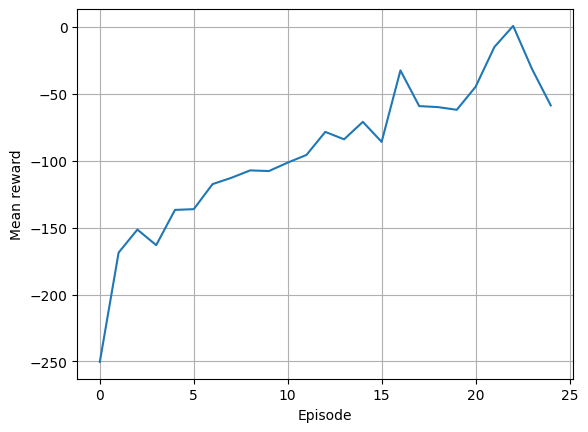

In [1]:
!sudo apt-get update && apt-get install -y swig cmake build-essential
%pip install --upgrade pip
%pip install -U setuptools wheel
%pip install -q -U gym[classic_control]
%pip install -q -U gym[box2d]
%pip install -q -U gym[atari]
%pip install -q -U gym[accept-rom-license]
import gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


def lander_play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        probas = model(obs[np.newaxis])  # shape of probas: (1, n_outputs)
        logits = tf.math.log(probas + tf.keras.backend.epsilon())  # ensure numerical stability
        action = tf.random.categorical(logits, num_samples=1)  # shape of action: (1, 1)
        loss = tf.reduce_mean(loss_fn(action, probas))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(action[0, 0].numpy())
    return obs, reward, done, truncated, grads

def lander_play_multiple_episodes(env, n_episodes, n):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = lander_play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

env = gym.make('LunarLander-v2', render_mode='rgb_array')
obs, info = env.reset(seed=42)

np.random.seed(42)
tf.random.set_seed(42)

n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=[n_inputs]),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs, activation="softmax")
])

n_iterations = 25
n_episodes_per_update = 16
n_max_steps = 1000
discount_rate = 0.99
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.sparse_categorical_crossentropy  # Ensure loss remains compatible

mean_rewards = []

for iteration in range(n_iterations):
    all_rewards, all_grads = lander_play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps)
    mean_reward = sum(map(sum, all_rewards)) / n_episodes_per_update
    print(f"\rIteration: {iteration + 1} / {n_iterations}, mean reward: {mean_reward:.1f}", end="")
    mean_rewards.append(mean_reward)
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

plt.plot(mean_rewards)
plt.xlabel("Episode")
plt.ylabel("Mean reward")
plt.grid()
plt.show()

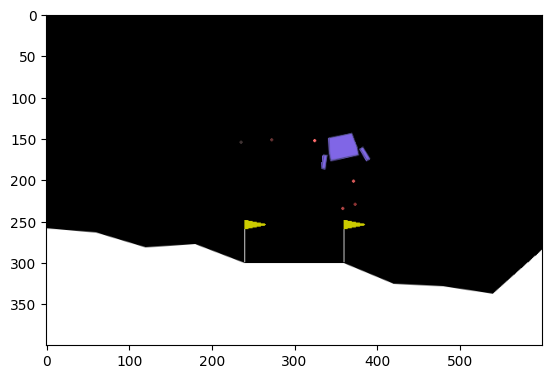

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation

def lander_render_policy_net(model, n_max_steps=500, seed=42):
    frames = []
    env = gym.make('LunarLander-v2', render_mode='rgb_array')
    tf.random.set_seed(seed)
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + tf.keras.backend.epsilon())  # ensure numerical stability
        action = tf.random.categorical(logits, num_samples=1)
        obs, reward, done, truncated, info = env.step(action[0, 0].numpy())
        if done:
            break
    env.close()
    return frames

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

frames = lander_render_policy_net(model, n_max_steps=1000)
# plot_animation(frames)
plt.imshow(frames[120])
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=968d3c27-50e7-4d42-bdd9-442f6904c1c2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>